In [9]:
from include.TriggerPrimitive import TriggerPrimitive as TriggerPrimitive
import numpy as np
import matplotlib.pyplot as plt
from include.TPFinder import TPFinder


In [7]:
#This is same function as in TPFinder, put here for testing
'''def TPFinder(waveform, thresh):

    is_hit = False

    hit_charge =[]    
    this_hit = TriggerPrimitive()
   
    hits = []
    true_adc_areas = []
    for tick, adc  in enumerate(waveform):
        if (adc > thresh and is_hit==False):
            is_hit = True
            this_hit.time_start =tick
            temp_tick = tick
            while (waveform[temp_tick]>0):
                temp_tick = temp_tick - 1
            true_start = temp_tick
            print(f"True Start: {true_start}")
            print(f"True Start ADC: {waveform[true_start]}")
            print(f"Time Start: {tick}")
            print(f"Time Start ADC: {waveform[tick]}")
           
        if(is_hit == True):
            hit_charge.append(adc)
           
        if (is_hit and adc<thresh):
            time_end  = tick
            is_hit = False
            temp_tick_f = tick
            while(waveform[temp_tick]>0):
                temp_tick_f+=1
            true_end = temp_tick_f
            print(f"True End: {true_end}")
            print(f"True End ADC: {waveform[true_end]}")
            print(f"Time End: {tick}")
            print(f"Time End ADC: {waveform[tick]}")
            
            true_adc = 0
            for i in range(true_start,true_end):
                true_adc = true_adc + waveform[i]
            true_adc_areas.append(true_adc)
           
            for index, ADC in enumerate(hit_charge):
                if (ADC == np.max(hit_charge)):
                    this_hit.adc_peak = ADC
                    this_hit.time_peak = index
            this_hit.adc_integral = np.sum(hit_charge)
            this_hit.time_over_threshold = time_end - this_hit.time_start
            hits.append(this_hit)

            #clean up for next hit
            hit_charge = []
            this_hit = TriggerPrimitive()
            
    return hits,true_adc_areas #return set of hits for waveform
    '''

In [3]:
#load waveform data (100 low energy electron events, 5 - 100 MeV)
col = np.loadtxt("/eos/home-e/evilla/dune/sn-data/standard/aggregated_prodmarley_nue_spectrum_radiological_decay0_dune10kt_refactored_1x2x6_CC-WFdump-1events_thr30/waveforms_tryWfDumper.txt")
ind = np.loadtxt("data/PedSubWaveform_Induction_Dump.txt")
event = 1
threshold = 30

In [4]:
#returns recovered area (not including adc_integral)
def recover_area(hit): 
    x1,y1,x2,y2= hit.time_start,threshold,hit.time_peak+hit.time_start,hit.adc_peak 
    slope = (y2-y1)/(x2-x1)
    start_x =(0-y1)/slope + x1
    end_x = x1
    
    x_values = np.linspace(start_x, end_x, 100)
    #y_values = slope * (x_values - x1) + y1
    area_left = (np.abs(start_x-end_x)*threshold)/2  #formula for triangle area

    #Find Equation of Negative Slope Line (Right Side)
    x1,y1,x2,y2= hit.time_start+hit.time_over_threshold,threshold,hit.time_peak+hit.time_start,hit.adc_peak 
    slope = (y2-y1)/(x2-x1)
    start_x = x1
    end_x = (0-y1)/slope + x1
    x_values = np.linspace(start_x, end_x, 100)
    #y_values = slope * (x_values - x1) + y1
    area_right = (np.abs(start_x-end_x)*threshold)/2  #formula for triangle area
    
    total_area = area_right+area_left
    return total_area

In [59]:
#Calculate true area and aprixumated area

recovered_area_list = []
#plot collection waveforms from event
fig1 = plt.figure()
offset = 0
count = 0
adc_integral = []
adc_plus_recovered = []
approximated_error = []
adjusted_approximated_error = []
adc_integral_error = []
adc_real_fraction = []
approximated_fraction = []
for data in col:
    pedestal = np.mean(data[3:15])
    data[2:] = data[2:] - pedestal
    if (data[0]==event):
        ADCS = data[2:]
        hits,true_areas = TPFinder(ADCS, threshold)
        for i,hit in enumerate(hits):
            recovered_area = recover_area(hit)
            recovered_area_list.append(recovered_area)
            adc_integral.append(hit.adc_integral)
            adc_integral_error.append(np.abs(hit.adc_integral-true_areas[i])/true_areas[i])
            approximated_area = recovered_area + hit.adc_integral
            
            #Strategy to cut out outliers (cant use true area)
            adjusted_approximated_area = (recovered_area + hit.adc_integral*2)/2 #take average of total new area and adc_integral
            if adjusted_approximated_area > hit.adc_integral*5: 
                adjusted_approximated_area = hit.adc_integral
                
            adc_plus_recovered.append(approximated_area)
            approximated_error.append(np.abs(approximated_area-true_areas[i])/true_areas[i])
            adjusted_approximated_error.append(np.abs(adjusted_approximated_area-true_areas[i])/true_areas[i])
            adc_real_fraction.append(hit.adc_integral/true_areas[i])
            approximated_fraction.append(approximated_area/true_areas[i])
    count+=1


/tmp/hakins/ipykernel_421277/573048239.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  slope = (y2-y1)/(x2-x1)


<Figure size 640x480 with 0 Axes>

Mean ADC_integral Error: 0.42522644183126923
Mean Approx Error: 1.1208525590204534
Mean Adjusted Approx Error: 0.24571211824358505


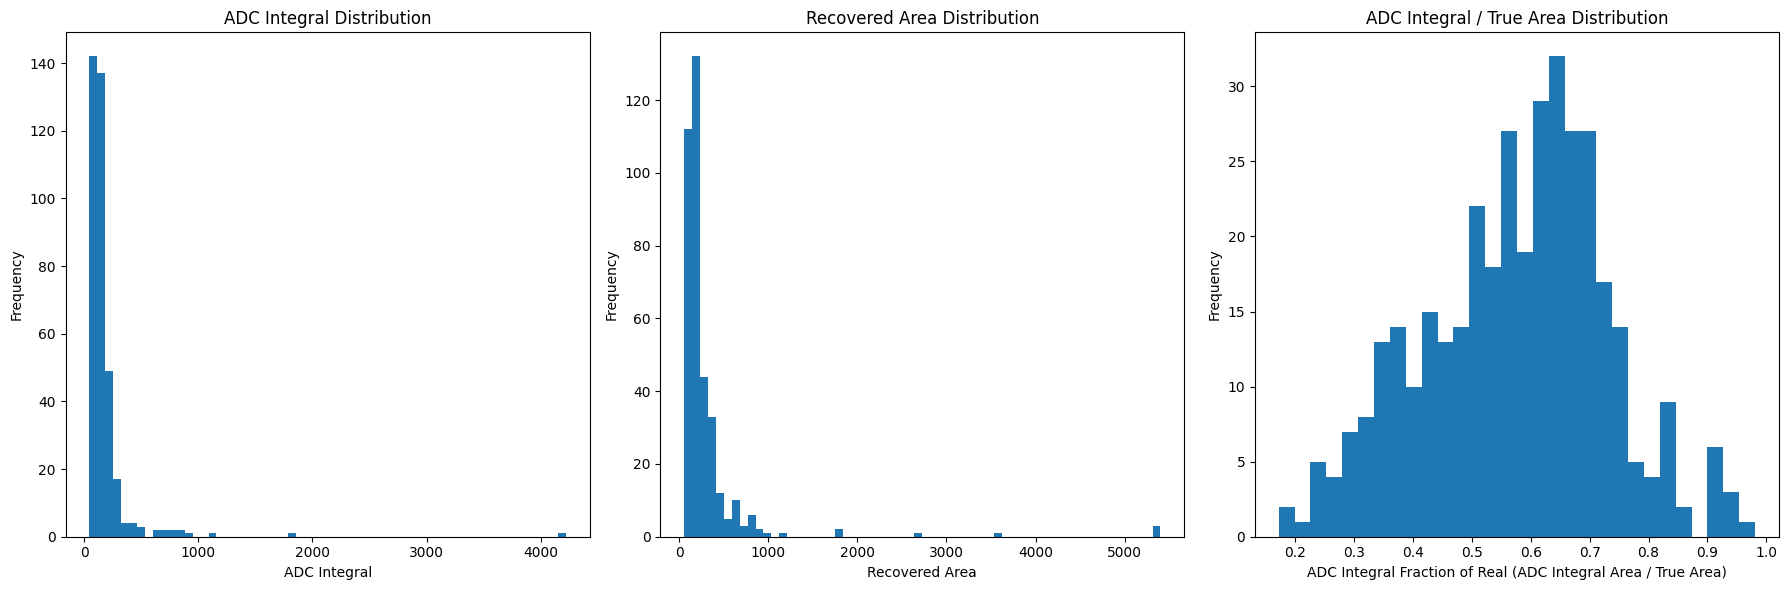

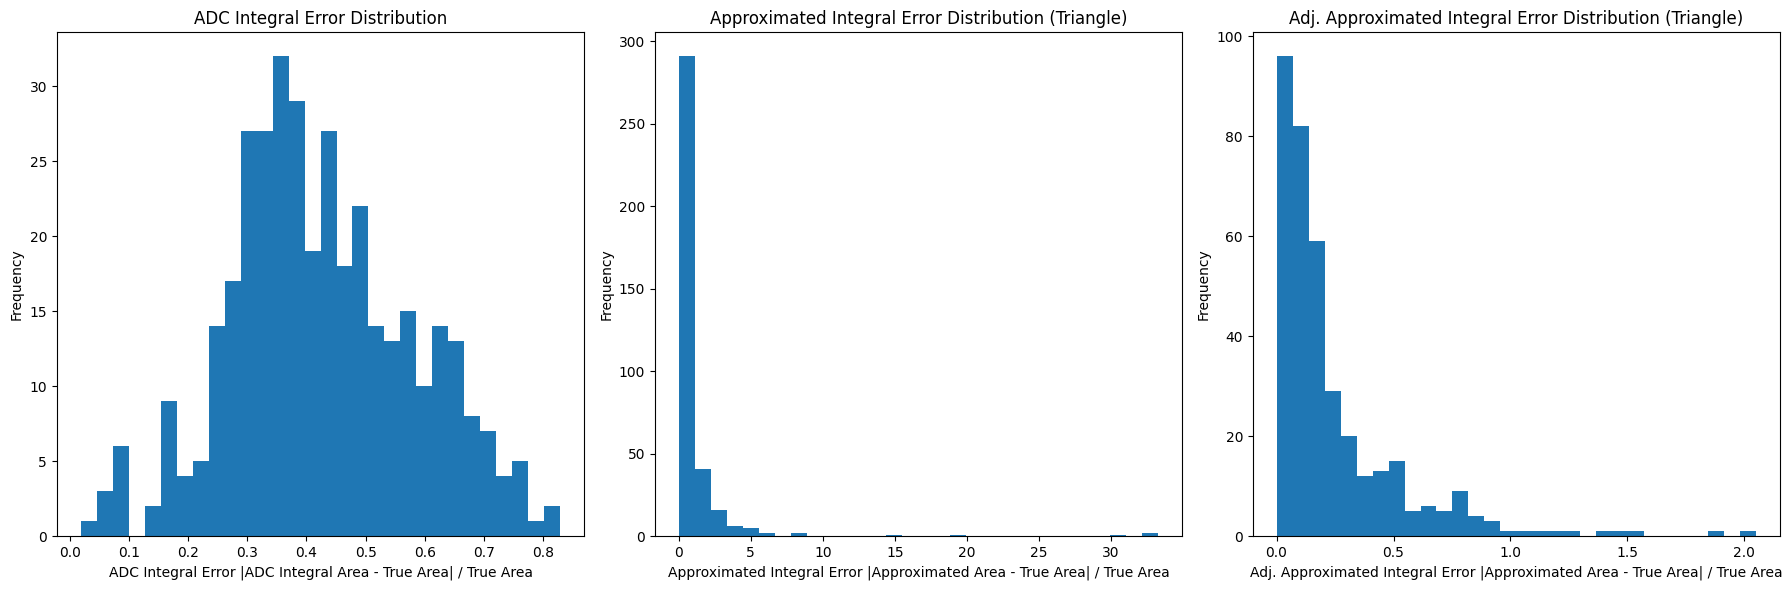

In [62]:


# Print mean errors
print(f"Mean ADC_integral Error: {np.mean(adc_integral_error)}")
print(f"Mean Approx Error: {np.mean(approximated_error)}")
print(f"Mean Adjusted Approx Error: {np.mean(adjusted_approximated_error)}")

# Create the first set of subplots
fig, axs1 = plt.subplots(1, 3, figsize=(18, 6))

# ADC Integral histogram
axs1[0].hist(adc_integral, bins=60)
axs1[0].set_title('ADC Integral Distribution')
axs1[0].set_xlabel('ADC Integral')
axs1[0].set_ylabel('Frequency')

# Recovered Area histogram
axs1[1].hist(recovered_area_list, bins=60)
axs1[1].set_title('Recovered Area Distribution')
axs1[1].set_xlabel('Recovered Area')
axs1[1].set_ylabel('Frequency')

# ADC Integral / True Area histogram
axs1[2].hist(adc_real_fraction, bins=30)
axs1[2].set_title('ADC Integral / True Area Distribution')
axs1[2].set_xlabel('ADC Integral Fraction of Real (ADC Integral Area / True Area)')
axs1[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create the second set of subplots
fig, axs2 = plt.subplots(1, 3, figsize=(18, 6))

# ADC Integral Error histogram
axs2[0].hist(adc_integral_error, bins=30)
axs2[0].set_title('ADC Integral Error Distribution')
axs2[0].set_xlabel('ADC Integral Error |ADC Integral Area - True Area| / True Area')
axs2[0].set_ylabel('Frequency')

# Approximated Integral Error histogram
axs2[1].hist(approximated_error, bins=30)
axs2[1].set_title('Approximated Integral Error Distribution (Triangle)')
axs2[1].set_xlabel('Approximated Integral Error |Approximated Area - True Area| / True Area')
axs2[1].set_ylabel('Frequency')

# Adj. Approximated Integral Error histogram
axs2[2].hist(adjusted_approximated_error, bins=30)
axs2[2].set_title('Adj. Approximated Integral Error Distribution (Triangle)')
axs2[2].set_xlabel('Adj. Approximated Integral Error |Approximated Area - True Area| / True Area')
axs2[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [6]:
def plot_dotted_line(x1, y1, x2, y2,y_max,y_min,plot):
    slope = (y2 - y1) / (x2 - x1)
    x_max = (y_max-y1)/slope + x1
    x_min = (y_min-y1)/slope + x1
    x_values = np.linspace(x_min, x_max, 100)
    y_values = slope * (x_values - x1) + y1
    if plot:
        plt.plot(x_values, y_values, 'r--',color='black')
    else:
        return [x_min,x_max,slope]




Below works properly but better visualized with reduced area of inspection (ADCS = data[2800:3000])

/tmp/hakins/ipykernel_2020565/2025387140.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, y_values, 'r--',color='black')


0
0
1
1


<Figure size 640x480 with 0 Axes>

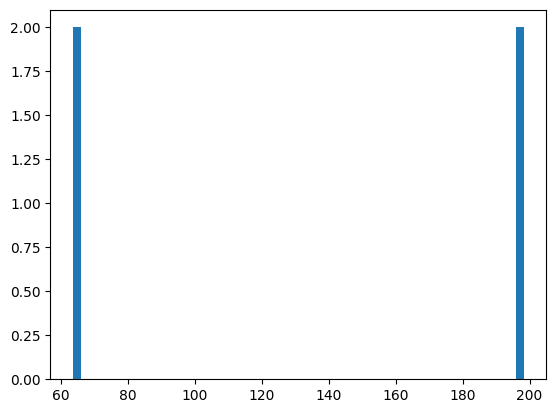

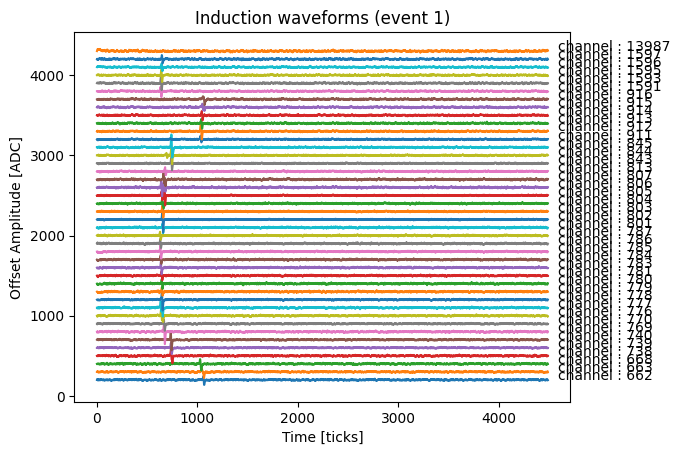

In [62]:
#Plots example wave form with triangle area recovery

event = 1
threshold = 30

#plot collection waveforms from event
fig1 = plt.figure()
offset = 0
count = 0
adc_integral = []
for j,data in enumerate(col):
    if count > 3:
        break
    pedestal = np.mean(data[3:15])
    if np.abs(pedestal-1800) < 100: #only want to pick up collection. 1800 indicates induction
        break
    data[3:] = data[3:] - pedestal
    if (data[0]==event):
        ADCS = data[3:]
        hits,list = TPFinder(ADCS, threshold)
        
        for i,hit in enumerate(hits):
            if hit.adc_peak-threshold > 0:
                plt.title("Collection waveforms (event %.0f)" %event)
                plt.plot(ADCS)#offset by channel number
                plt.plot(hit.time_start-.5,threshold ,'o', color='red')
                plt.plot(hit.time_start+hit.time_peak,hit.adc_peak, 'o')
                plt.plot(hit.time_start-.5+hit.time_over_threshold,threshold, 'o',color='red')
                #vertical dotted lines
                #plt.plot([hit.time_start - 0.5, hit.time_start - 0.5], [0, threshold], 'r--')
                #plt.plot([hit.time_start - 0.5 + hit.time_over_threshold, hit.time_start - 0.5 + hit.time_over_threshold], [0, threshold], 'r--')
    
                #traingle dotted lines
                # Plotting the dotted lines
                pos_slope_args = [hit.time_start+hit.time_peak, hit.adc_peak, hit.time_start - 0.5, threshold,hit.adc_peak,0]
                plot_dotted_line(pos_slope_args[0],pos_slope_args[1],pos_slope_args[2],pos_slope_args[3],pos_slope_args[4],pos_slope_args[5],True)
                neg_slope_args = [hit.time_start+hit.time_peak, hit.adc_peak, hit.time_start - 0.5 + hit.time_over_threshold, threshold,hit.adc_peak,0]
                plot_dotted_line(neg_slope_args[0],neg_slope_args[1],neg_slope_args[2],neg_slope_args[3],neg_slope_args[4],neg_slope_args[5],True)
                #plt.plot([34,hit.time_start - 0.5], [hit.adc_peak, threshold], 'r--', color='black')
                #plt.plot([34, hit.time_start - 0.5 + hit.time_over_threshold], [hit.adc_peak, threshold], 'r--',color='black')
                
                #adding text
                plt.text(hit.time_start - 0.5 - 1, threshold, '(time_start, threshold)', fontsize=9, ha='right')
                plt.text(hit.time_start+hit.time_peak, hit.adc_peak, '(time_peak,adc_peak)', fontsize=9, ha='right')
                plt.text(hit.time_start - 0.5 + hit.time_over_threshold+30, threshold, '(time_start + time_over_threshold, threshold)', fontsize=6.5, ha='right')
                
                #shading adc_integral area
                x_positions = np.arange(len(ADCS))
                start = (hit.time_start - 0.5)
                end = (hit.time_start - 0.5 + hit.time_over_threshold)
                plt.fill_between(
                x_positions, 0, ADCS,
                where=(x_positions >= start) & (x_positions <= end),
                color='gray', alpha=0.5, label='Shaded Region')

                print(hit.time_peak)
                adc_integral.append(hit.adc_integral)
                count+=1
                
                #shading traingle arae
                args = plot_dotted_line(pos_slope_args[0],pos_slope_args[1],pos_slope_args[2],pos_slope_args[3],pos_slope_args[4],pos_slope_args[5],False)

                x_min = args[0]
                x_max = args[1]
                slope = args[2]
                x_values = np.linspace(x_min,hit.time_start - 0.5,100)
                y_values = slope * (x_values - hit.time_start - 0.5) + threshold+7
                plt.fill_between(x_values, y_values, alpha=0.3, color='blue')
                args = plot_dotted_line(neg_slope_args[0],neg_slope_args[1],neg_slope_args[2],neg_slope_args[3],neg_slope_args[4],neg_slope_args[5],False)

                x_min = args[0]
                x_max = args[1]
                slope = args[2]
                x_values = np.linspace(hit.time_start-.5+hit.time_over_threshold,x_min,100)
                y_values = slope * (x_values - hit.time_start - 0.5) + threshold+12
                plt.fill_between(x_values, y_values, alpha=0.3, color='blue')


                print(hit.time_peak)
                adc_integral.append(hit.adc_integral)
                count+=1
                plt.ylabel("Offset Amplitude [ADC]")
                plt.xlabel("Time [ticks]")
                plt.savefig(f'/afs/cern.ch/work/h/hakins/private/tp-generator/plots/{i}_{j}_wave_with_recovered_area.png')
                plt.clf()
                
    
           
        #plt.text(len(ADCS) + 100, offset, 'channel : %.0f' %data[1])
        offset+=100
        
plt.show()

plt.hist(adc_integral, bins=60)
plt.show()

#plot induction waveforms for event
for data in ind:
    if (data[0]==event):
        ADCS = data[2:]
        plt.title("Induction waveforms (event %.0f)" %event)
        plt.plot(ADCS + offset)#offset by channel number
        plt.text(len(ADCS) + 100, offset, 'channel : %.0f' %data[1])
        offset+=100
        plt.ylabel("Offset Amplitude [ADC]")
        plt.xlabel("Time [ticks]")
plt.show()
